In [1]:
import warnings
warnings.simplefilter(action='ignore', category=UserWarning) # Ignore User Warning regarding Shapely

import matplotlib.pyplot as plt
import contextily
import pandas as pd
import geopandas as gpd
import pymssql
from shapely import wkb
from tobler.area_weighted import area_interpolate
import os

# Rasterio Installation bug where the Environment variable 'PROJ_LIB' isn't looking in the right file for 'Proj.db' SQLlite Database
# After installation of contextily (and by extension rasterio), you need to find the folder where rasterio is storing the 'Proj.db' file and set the environment variable 'PROJ_LIB' to use the right file path
os.environ['PROJ_LIB'] = '/Users/ahadhussain/opt/anaconda3/lib/python3.9/site-packages/rasterio/proj_data/'

In [2]:
database = 'Pushing-P-DB'
table1 = 'dbo.NJ_Cities'
table2 = 'dbo.NJ_Census_Tracts'
user = 'pushing_p'
password  = 't3stP@ssword'
server = 'gen10-data-fundamentals-22-02-sql-server.database.windows.net'


# Retrieve Training Data for Geographically Weighted Regression Model
conn = pymssql.connect(server, user, password, database)

# Query select all rows from SQL tables to insert into their respective DataFrames
query1 = f'SELECT * FROM {table1}'
query2 = f'SELECT * FROM {table2}'
df = pd.read_sql(query1, conn)
tract_info = pd.read_sql(query2, conn)

# Use a function to convert wkb_hex string in SQL database to polygonal geometries (WKB stands for Well-Known Binary, which is commonly used for encoding geographic polygons)
# WKT, well-known text, markup can also be used

def convert_to_polygon(line):
    return wkb.loads(line, hex=True)
df['geometry'] = df['geometry'].apply(convert_to_polygon)
tract_info['geometry'] = tract_info['geometry'].apply(convert_to_polygon)

# Convert from pandas to geopandas dataframes
df = gpd.GeoDataFrame(df, geometry=df['geometry'], crs = 'epsg:4269')
tract_info = gpd.GeoDataFrame(tract_info, geometry=tract_info['geometry'], crs = 'epsg:4269')

# Add % Uninsured Column
df['% Uninsured'] = df['Uninsured Population']/df['City Population']*100
tract_info['% Uninsured'] = tract_info['Uninsured Population']/tract_info['City Population']*100



In [3]:
df.head()


,State,County,City,Unemployment Rate (16 & Over),Median Household Income,City Population,Uninsured Population,"NUI, Under 6 years","NUI, 6-18 years","NUI, 19 to 25 years",...,"NUI, Men","NUI, Women","NUI, White","NUI, African American","NUI, American Indian & Alaska Natives","NUI, Asians","NUI, Native Hawaiians & Pacific Islanders","NUI, Other Races",geometry,% Uninsured
0,New Jersey,Bergen County,River Edge Borough,1.6,128231,11510,273,0,16,36,...,130,143,159,0,0,87,0,27,"POLYGON ((-74.05040 40.92770, -74.04823 40.932...",2.371851
1,New Jersey,Somerset County,Franklin Township,5.1,93567,65230,4431,96,1056,540,...,2341,2090,1094,728,14,598,0,1759,"POLYGON ((-74.63746 40.40929, -74.63632 40.412...",6.792887
2,New Jersey,Essex County,Montclair Township,4.8,134308,38477,1387,42,197,315,...,725,662,638,681,0,0,0,23,"POLYGON ((-74.23729 40.80315, -74.23433 40.812...",3.604751
3,New Jersey,Burlington County,Washington Township,7.5,65893,609,27,0,0,0,...,15,12,23,0,0,0,0,4,"POLYGON ((-74.68734 39.73152, -74.62737 39.747...",4.433498
4,New Jersey,Union County,Plainfield,8.5,58400,49913,12333,742,1034,1921,...,7020,5313,3416,1739,191,55,0,6349,"POLYGON ((-74.45988 40.60003, -74.45738 40.602...",24.708994


In [4]:
df.shape

(559, 25)

In [5]:
tract_info.head()

,State,County,Census Tract,Unemployment Rate (16 & Over),Median Household Income,City Population,Uninsured Population,"NUI, Under 6 years","NUI, 6-18 years","NUI, 19 to 25 years",...,"NUI, Men","NUI, Women","NUI, White","NUI, African American","NUI, American Indian & Alaska Natives","NUI, Asians","NUI, Native Hawaiians & Pacific Islanders","NUI, Other Races",geometry,% Uninsured
0,New Jersey,Ocean County,Census Tract 7174,4.600000,104295.0,5929.0,245.0,0.0,31.0,47.0,...,121.0,124.0,225.0,0.0,0.0,0.0,0.0,20.0,"POLYGON ((-74.45600 40.08830, -74.39499 40.103...",4.132231
1,New Jersey,Essex County,Census Tract 19,25.799999,22294.0,2011.0,121.0,0.0,0.0,42.0,...,43.0,78.0,0.0,121.0,0.0,0.0,0.0,0.0,"POLYGON ((-74.21921 40.74173, -74.21787 40.745...",6.016907
2,New Jersey,Middlesex County,Census Tract 8.01,2.800000,126991.0,4044.0,262.0,22.0,60.0,69.0,...,155.0,107.0,83.0,13.0,0.0,0.0,0.0,166.0,"POLYGON ((-74.44093 40.59408, -74.43748 40.597...",6.478734
3,New Jersey,Essex County,Census Tract 206,1.800000,168154.0,5139.0,10.0,0.0,10.0,0.0,...,0.0,10.0,0.0,0.0,0.0,0.0,0.0,0.0,"POLYGON ((-74.32586 40.77322, -74.32442 40.774...",0.194590
4,New Jersey,Camden County,Census Tract 6078.01,2.300000,48402.0,5361.0,638.0,105.0,29.0,0.0,...,524.0,114.0,122.0,403.0,0.0,0.0,0.0,0.0,"POLYGON ((-75.02797 39.82127, -75.02726 39.821...",11.900765


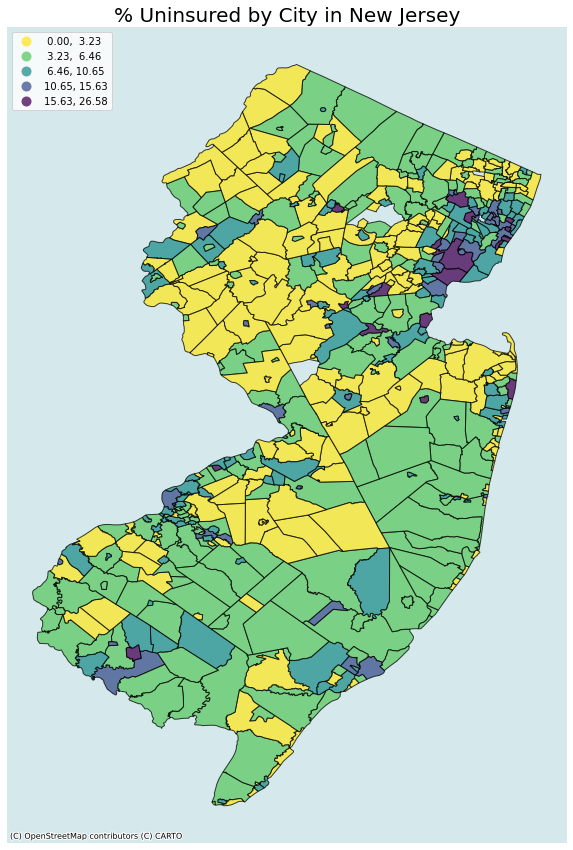

In [6]:
# Set up figure and a single axis
f, ax = plt.subplots(1, figsize=(15, 15))

# Build choropleth
df.plot(
    column='% Uninsured', 
    cmap='viridis_r', 
    scheme='natural_breaks',
    k=5, 
    edgecolor='black', 
    linewidth=1, 
    alpha=0.75, 
    legend=True,
    legend_kwds=dict(loc=2),
    ax=ax
)
# Add basemap
contextily.add_basemap(
    ax, 
    source=contextily.providers.CartoDB.Voyager,
)

plt.title('% Uninsured by City in New Jersey', fontsize=20)
ax.set_axis_off();

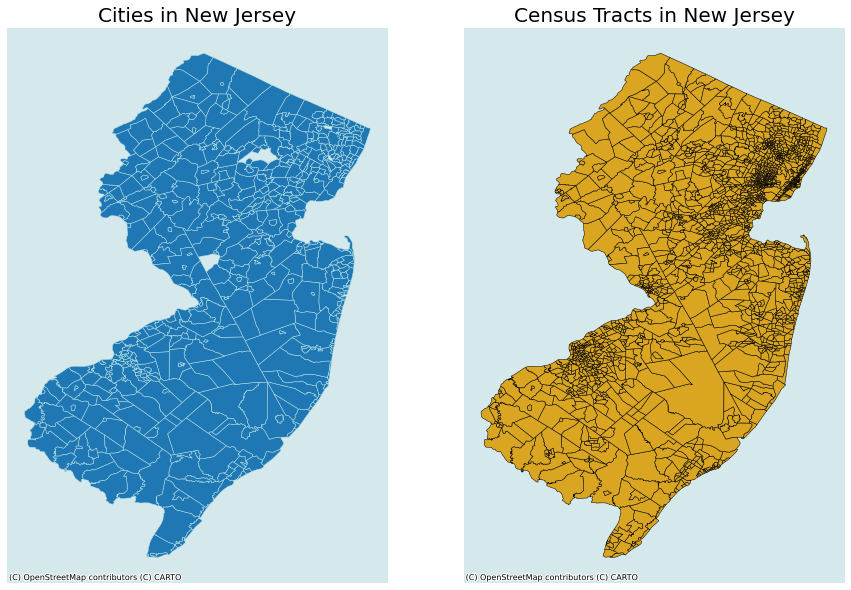

In [7]:
fig, ax = plt.subplots(1,2, figsize=(15,20))

df.plot(ax=ax[0], edgecolor = 'powderblue', linewidth = 0.5)
tract_info.plot(ax=ax[1], color = 'goldenrod',edgecolor = 'black', linewidth = 0.5)


# Add basemap
contextily.add_basemap(
    ax[0], 
    source=contextily.providers.CartoDB.Voyager,
)

contextily.add_basemap(
    ax[1], 
    source=contextily.providers.CartoDB.Voyager
)
ax[0].set_title('Cities in New Jersey', fontsize=20)
ax[1].set_title('Census Tracts in New Jersey', fontsize=20)
ax[0].axis('off')
ax[1].axis('off');


#### Areal Interpolation:
- Areal interpolation is the process making estimates from a source set of polygons to an overlapping but incongruent set of target polygons. 

- The simplest technique available in `tobler` is **simple areal interpolation** in which variables from the source data are weighted according to the overlap between source and target polygons, then reaggregated to fit the target polygon geometries

- In addition to geometric overlap, the values of each of the variables are also determined by whether the variable is **intensive** or **extensive**
    - Intensive Property: independent of size of system (Population Density, Concentration, Melting Point, etc.)

    - Extensive Property: dependent on size of system (Population Count, Mass, Volume, etc.)
    

- We are going to use data at the *city* level to predict data at the *census tract* level (a census tract is an area created for the purpose of taking a census)

In [8]:
# Drop rows with null values (about 175 counties are missing healthcare information so we drop those from our analysis)
tract_info.dropna(inplace=True)
tract_info.shape

(1809, 25)

In [9]:
extensive_variables = list(df.drop(['State','County','City','geometry','Unemployment Rate (16 & Over)', '% Uninsured'], axis=1).columns)
results = area_interpolate(source_df=df, target_df=tract_info, intensive_variables = ['Unemployment Rate (16 & Over)'], extensive_variables=extensive_variables)

In [10]:
# Create Uninsurance rate columns
col_dict = {
'NUI, Under 6 years': '% Uninsured, Under 6 years',
'NUI, 6-18 years': '% Uninsured, 6-18 years',
'NUI, 19 to 25 years': '% Uninsured, 19 to 25 years',
'NUI, 26 to 34 years': '% Uninsured, 26 to 34 years',
'NUI, 35 to 44 years': '% Uninsured, 35 to 44 years',
'NUI, 45 to 54 years': '% Uninsured, 45 to 54 years',
'NUI, 55 to 64 years': '% Uninsured, 55 to 64 years',
'NUI, 65 years and older': '% Uninsured, 65 years and older',
'NUI, Men': '% Uninsured, Men',
'NUI, Women': '% Uninsured, Women',
'NUI, White': '% Uninsured, White',
'NUI, African American': '% Uninsured, African American',
'NUI, American Indian & Alaska Natives': '% Uninsured, American Indian & Alaska Natives',
'NUI, Asians': '% Uninsured, Asians',
'NUI, Native Hawaiians & Pacific Islanders': '% Uninsured, Native Hawaiians & Pacific Islanders',
'NUI, Other Races': '% Uninsured, Other Races'}

percent_cols = list(col_dict.values())
numeric_cols = list(col_dict.keys())

results.shape

(1809, 21)

In [11]:
results['% Uninsured'] = results['Uninsured Population']/results['City Population']*100

tract_info[percent_cols] = tract_info[numeric_cols].div(tract_info['Uninsured Population'], axis=0)
tract_info[percent_cols] = tract_info[percent_cols].apply(lambda x: x * 100)
results[percent_cols] = results[numeric_cols].div(results['Uninsured Population'], axis=0)
results[percent_cols] = results[percent_cols].apply(lambda x: x * 100)


In [12]:
tract_info.head()

,State,County,Census Tract,Unemployment Rate (16 & Over),Median Household Income,City Population,Uninsured Population,"NUI, Under 6 years","NUI, 6-18 years","NUI, 19 to 25 years",...,"% Uninsured, 55 to 64 years","% Uninsured, 65 years and older","% Uninsured, Men","% Uninsured, Women","% Uninsured, White","% Uninsured, African American","% Uninsured, American Indian & Alaska Natives","% Uninsured, Asians","% Uninsured, Native Hawaiians & Pacific Islanders","% Uninsured, Other Races"
0,New Jersey,Ocean County,Census Tract 7174,4.600000,104295.0,5929.0,245.0,0.0,31.0,47.0,...,26.938776,0.0,49.387755,50.612245,91.836735,0.000000,0.0,0.0,0.0,8.163265
1,New Jersey,Essex County,Census Tract 19,25.799999,22294.0,2011.0,121.0,0.0,0.0,42.0,...,19.008264,0.0,35.537190,64.462810,0.000000,100.000000,0.0,0.0,0.0,0.000000
2,New Jersey,Middlesex County,Census Tract 8.01,2.800000,126991.0,4044.0,262.0,22.0,60.0,69.0,...,4.961832,0.0,59.160305,40.839695,31.679389,4.961832,0.0,0.0,0.0,63.358779
3,New Jersey,Essex County,Census Tract 206,1.800000,168154.0,5139.0,10.0,0.0,10.0,0.0,...,0.000000,0.0,0.000000,100.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000
4,New Jersey,Camden County,Census Tract 6078.01,2.300000,48402.0,5361.0,638.0,105.0,29.0,0.0,...,13.166144,0.0,82.131661,17.868339,19.122257,63.166144,0.0,0.0,0.0,0.000000


In [13]:
results.head()

,Median Household Income,City Population,Uninsured Population,"NUI, Under 6 years","NUI, 6-18 years","NUI, 19 to 25 years","NUI, 26 to 34 years","NUI, 35 to 44 years","NUI, 45 to 54 years","NUI, 55 to 64 years",...,"% Uninsured, 55 to 64 years","% Uninsured, 65 years and older","% Uninsured, Men","% Uninsured, Women","% Uninsured, White","% Uninsured, African American","% Uninsured, American Indian & Alaska Natives","% Uninsured, Asians","% Uninsured, Native Hawaiians & Pacific Islanders","% Uninsured, Other Races"
0,36417.990351,21036.575044,845.104359,29.116112,53.072406,118.307239,206.761250,146.686234,189.807564,101.353554,...,11.993022,0.000000,59.572612,40.427388,75.403402,7.806367,0.000000,10.815526,0.00000,5.931095
1,572.667482,4181.896798,722.084245,25.595529,72.553773,86.214909,167.219027,163.948912,123.592021,68.229275,...,9.448936,2.040039,52.467516,47.532484,35.144115,31.849156,0.368223,1.172388,0.11216,21.742075
2,21069.321397,4624.802080,213.721914,10.705560,16.934250,30.948802,32.116681,51.581336,42.238302,21.216474,...,9.927140,3.734062,61.202186,38.797814,53.278689,10.837887,0.000000,13.205829,0.00000,22.677596
3,25915.133368,4587.558197,90.021639,3.082933,7.399039,15.568811,4.624399,14.335638,5.549279,20.963943,...,23.287671,20.547945,32.020548,67.979452,32.876712,0.000000,0.000000,60.273973,0.00000,5.136986
4,10637.857801,3991.303376,603.728501,24.241489,54.947374,82.190190,167.381707,152.836814,42.942065,79.188863,...,13.116635,0.000000,62.217973,37.782027,26.539197,28.757170,0.000000,0.000000,0.00000,37.858509


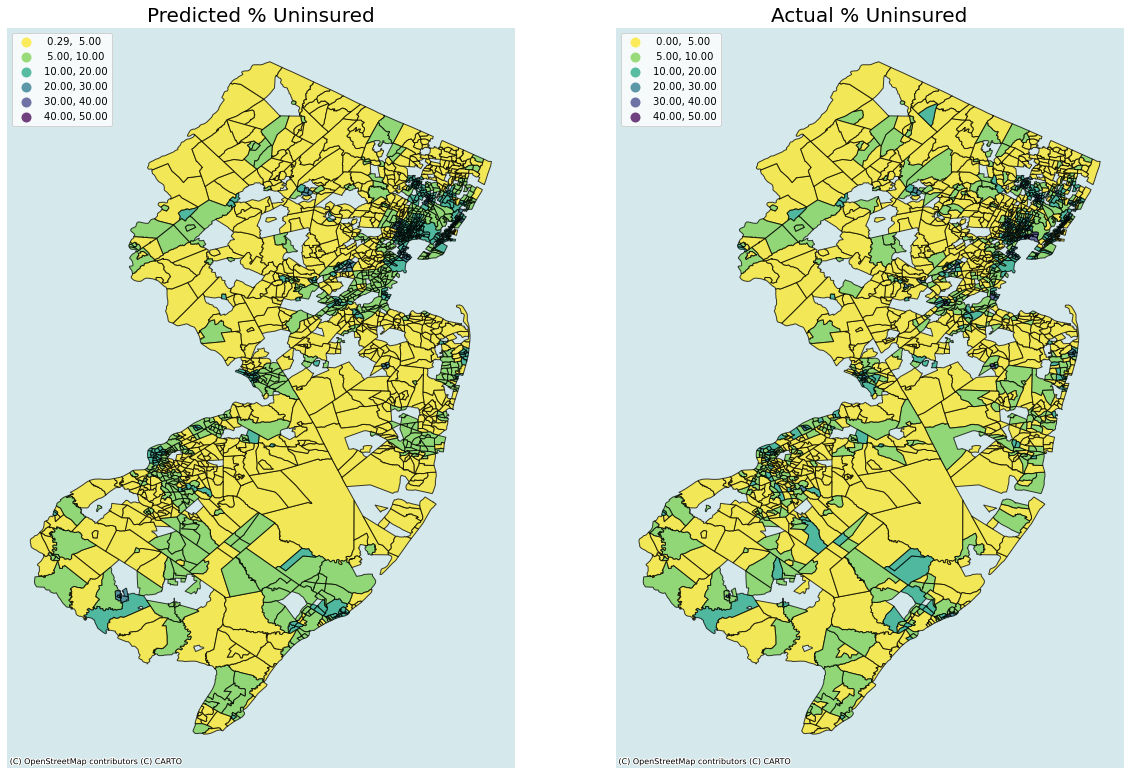

In [14]:
# Set up figure and a single axis
f, ax = plt.subplots(1,2, figsize=(20, 20))

# Build Predicted choropleth
results.plot(
    column='% Uninsured', 
    cmap='viridis_r', 
    scheme="User_Defined",
    classification_kwds=dict(bins=[5,10,20,30,40,50]),
    edgecolor='black', 
    linewidth=1, 
    alpha=0.75, 
    legend=True,
    legend_kwds=dict(loc=2),
    ax=ax[0]
)

# Build choropleth
tract_info.plot(
    column='% Uninsured', 
    cmap='viridis_r', 
    scheme="User_Defined",
    classification_kwds=dict(bins=[5,10,20,30,40,50]),
    edgecolor='black', 
    linewidth=1, 
    alpha=0.75, 
    legend=True,
    legend_kwds=dict(loc=2),
    ax=ax[1]
)


# Add basemap
contextily.add_basemap(
    ax[0], 
    source=contextily.providers.CartoDB.Voyager,
)

contextily.add_basemap(
    ax[1], 
    source=contextily.providers.CartoDB.Voyager
)

ax[0].set_title('Predicted % Uninsured',fontsize=20)
ax[1].set_title('Actual % Uninsured',fontsize=20)
ax[0].axis('off')
ax[1].axis('off');

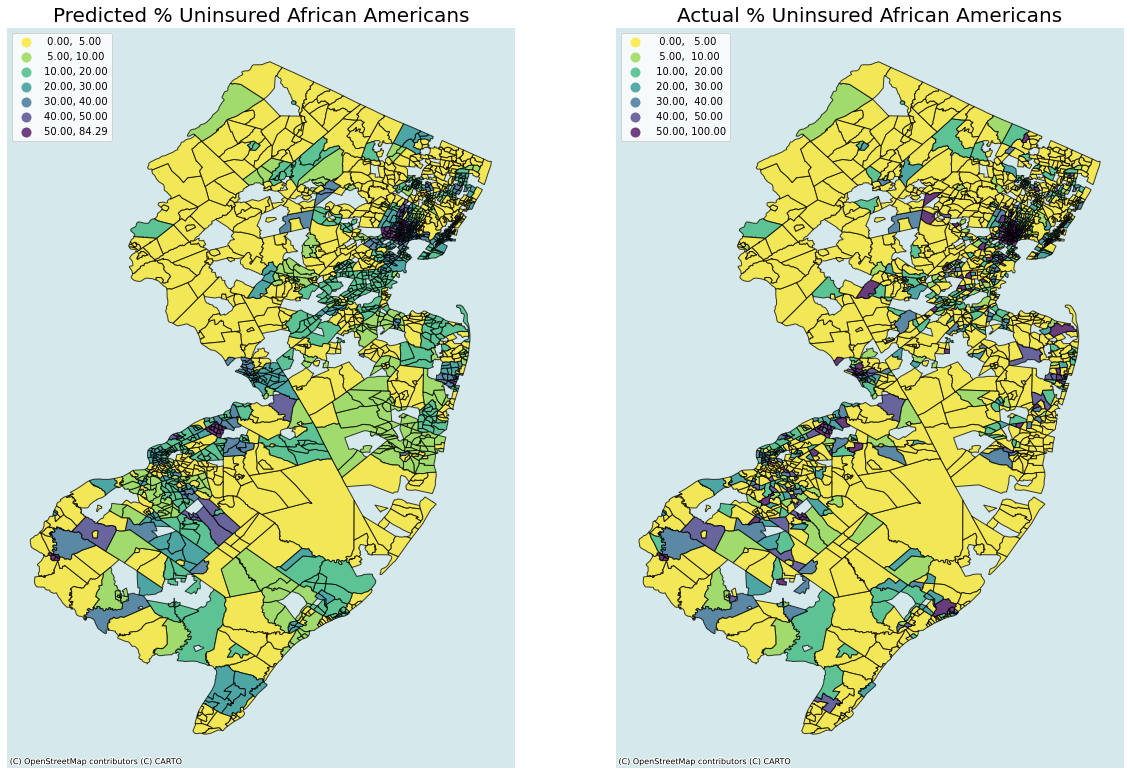

In [15]:
# Set up figure and a single axis
f, ax = plt.subplots(1,2, figsize=(20, 20))

# Build Predicted choropleth
results.plot(
    column='% Uninsured, African American', 
    cmap='viridis_r', 
    scheme="User_Defined",
    classification_kwds=dict(bins=[5,10,20,30,40,50]),
    edgecolor='black', 
    linewidth=1, 
    alpha=0.75, 
    legend=True,
    legend_kwds=dict(loc=2),
    ax=ax[0]
)

# Build choropleth
tract_info.plot(
    column='% Uninsured, African American', 
    cmap='viridis_r', 
    scheme="User_Defined",
    classification_kwds=dict(bins=[5,10,20,30,40,50]),
    edgecolor='black', 
    linewidth=1, 
    alpha=0.75, 
    legend=True,
    legend_kwds=dict(loc=2),
    ax=ax[1]
)


# Add basemap
contextily.add_basemap(
    ax[0], 
    source=contextily.providers.CartoDB.Voyager,
)

contextily.add_basemap(
    ax[1], 
    source=contextily.providers.CartoDB.Voyager
)

ax[0].set_title('Predicted % Uninsured African Americans',fontsize=20)
ax[1].set_title('Actual % Uninsured African Americans',fontsize=20)
ax[0].axis('off')
ax[1].axis('off');

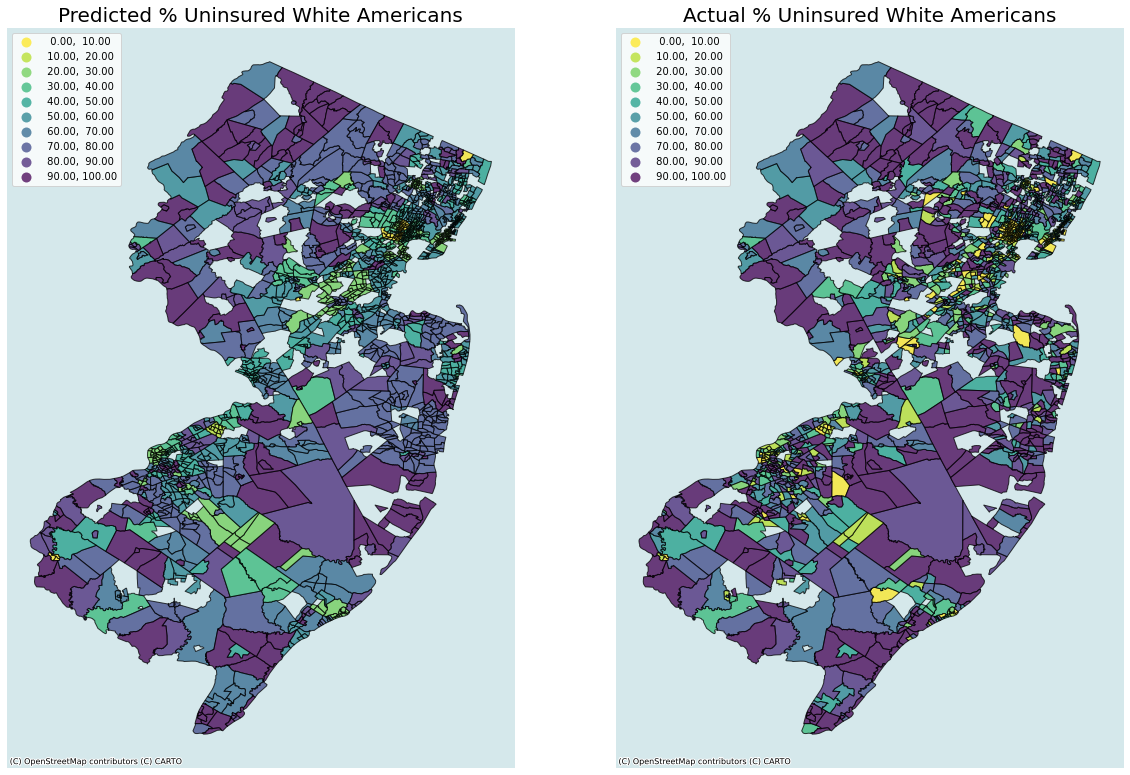

In [16]:
# Set up figure and a single axis
f, ax = plt.subplots(1,2, figsize=(20, 20))

# Build Predicted choropleth
results.plot(
    column='% Uninsured, White', 
    cmap='viridis_r', 
    scheme="User_Defined",
    classification_kwds=dict(bins=[10,20,30,40,50,60,70,80,90,100]),
    edgecolor='black', 
    linewidth=1, 
    alpha=0.75, 
    legend=True,
    legend_kwds=dict(loc=2),
    ax=ax[0]
)

# Build choropleth
tract_info.plot(
    column='% Uninsured, White', 
    cmap='viridis_r', 
    scheme="User_Defined",
    classification_kwds=dict(bins=[10,20,30,40,50,60,70,80,90,100]),
    edgecolor='black', 
    linewidth=1, 
    alpha=0.75, 
    legend=True,
    legend_kwds=dict(loc=2),
    ax=ax[1]
)


# Add basemap
contextily.add_basemap(
    ax[0], 
    source=contextily.providers.CartoDB.Voyager,
)

contextily.add_basemap(
    ax[1], 
    source=contextily.providers.CartoDB.Voyager
)

ax[0].set_title('Predicted % Uninsured White Americans',fontsize=20)
ax[1].set_title('Actual % Uninsured White Americans',fontsize=20)
ax[0].axis('off')
ax[1].axis('off');

In [17]:
# Rearrange columns
cols = list(tract_info.columns)
cols.remove('State'); cols.remove('County'); cols.remove('Census Tract'); cols.remove('Unemployment Rate (16 & Over)');
cols.remove('geometry'); cols.remove('Median Household Income'); cols.remove('City Population'); cols.remove('Uninsured Population')
tract_info['% Uninsured'] = tract_info['Uninsured Population']/tract_info['City Population'] * 100
 
cols = ['State','County','Census Tract', 'Unemployment Rate (16 & Over)', 'Median Household Income', 'City Population', 'Uninsured Population', '% Uninsured'] + cols + ['geometry']
tract_info = tract_info[cols]

tract_info.head()

,State,County,Census Tract,Unemployment Rate (16 & Over),Median Household Income,City Population,Uninsured Population,% Uninsured,"NUI, Under 6 years","NUI, 6-18 years",...,"% Uninsured, 65 years and older","% Uninsured, Men","% Uninsured, Women","% Uninsured, White","% Uninsured, African American","% Uninsured, American Indian & Alaska Natives","% Uninsured, Asians","% Uninsured, Native Hawaiians & Pacific Islanders","% Uninsured, Other Races",geometry
0,New Jersey,Ocean County,Census Tract 7174,4.600000,104295.0,5929.0,245.0,4.132231,0.0,31.0,...,0.0,49.387755,50.612245,91.836735,0.000000,0.0,0.0,0.0,8.163265,"POLYGON ((-74.45600 40.08830, -74.39499 40.103..."
1,New Jersey,Essex County,Census Tract 19,25.799999,22294.0,2011.0,121.0,6.016907,0.0,0.0,...,0.0,35.537190,64.462810,0.000000,100.000000,0.0,0.0,0.0,0.000000,"POLYGON ((-74.21921 40.74173, -74.21787 40.745..."
2,New Jersey,Middlesex County,Census Tract 8.01,2.800000,126991.0,4044.0,262.0,6.478734,22.0,60.0,...,0.0,59.160305,40.839695,31.679389,4.961832,0.0,0.0,0.0,63.358779,"POLYGON ((-74.44093 40.59408, -74.43748 40.597..."
3,New Jersey,Essex County,Census Tract 206,1.800000,168154.0,5139.0,10.0,0.194590,0.0,10.0,...,0.0,0.000000,100.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,"POLYGON ((-74.32586 40.77322, -74.32442 40.774..."
4,New Jersey,Camden County,Census Tract 6078.01,2.300000,48402.0,5361.0,638.0,11.900765,105.0,29.0,...,0.0,82.131661,17.868339,19.122257,63.166144,0.0,0.0,0.0,0.000000,"POLYGON ((-75.02797 39.82127, -75.02726 39.821..."


In [18]:
# Add state, county, and census tract columns to results

results[['State','County','Census Tract']] = tract_info[['State','County','Census Tract']].copy()

# Rearrange columns
cols = list(results.columns)
cols.remove('State'); cols.remove('County'); cols.remove('Census Tract'); cols.remove('Unemployment Rate (16 & Over)');
cols.remove('geometry'); cols.remove('Median Household Income'); cols.remove('City Population'); cols.remove('Uninsured Population')
results['% Uninsured'] = results['Uninsured Population']/results['City Population'] * 100
 
cols = ['State','County','Census Tract', 'Unemployment Rate (16 & Over)', 'Median Household Income', 'City Population', 'Uninsured Population', '% Uninsured'] + cols + ['geometry']
results = results[cols]

results.head()

,State,County,Census Tract,Unemployment Rate (16 & Over),Median Household Income,City Population,Uninsured Population,% Uninsured,"NUI, Under 6 years","NUI, 6-18 years",...,"% Uninsured, 65 years and older","% Uninsured, Men","% Uninsured, Women","% Uninsured, White","% Uninsured, African American","% Uninsured, American Indian & Alaska Natives","% Uninsured, Asians","% Uninsured, Native Hawaiians & Pacific Islanders","% Uninsured, Other Races",geometry
0,New Jersey,Ocean County,Census Tract 7174,4.1,36417.990351,21036.575044,845.104359,4.017310,29.116112,53.072406,...,0.000000,59.572612,40.427388,75.403402,7.806367,0.000000,10.815526,0.00000,5.931095,"POLYGON ((-74.45600 40.08830, -74.39499 40.103..."
1,New Jersey,Essex County,Census Tract 19,10.6,572.667482,4181.896798,722.084245,17.266907,25.595529,72.553773,...,2.040039,52.467516,47.532484,35.144115,31.849156,0.368223,1.172388,0.11216,21.742075,"POLYGON ((-74.21921 40.74173, -74.21787 40.745..."
2,New Jersey,Middlesex County,Census Tract 8.01,5.9,21069.321397,4624.802080,213.721914,4.621212,10.705560,16.934250,...,3.734062,61.202186,38.797814,53.278689,10.837887,0.000000,13.205829,0.00000,22.677596,"POLYGON ((-74.44093 40.59408, -74.43748 40.597..."
3,New Jersey,Essex County,Census Tract 206,3.8,25915.133368,4587.558197,90.021639,1.962300,3.082933,7.399039,...,20.547945,32.020548,67.979452,32.876712,0.000000,0.000000,60.273973,0.00000,5.136986,"POLYGON ((-74.32586 40.77322, -74.32442 40.774..."
4,New Jersey,Camden County,Census Tract 6078.01,5.2,10637.857801,3991.303376,603.728501,15.126099,24.241489,54.947374,...,0.000000,62.217973,37.782027,26.539197,28.757170,0.000000,0.000000,0.00000,37.858509,"POLYGON ((-75.02797 39.82127, -75.02726 39.821..."


In [19]:
# Export Model using joblib

from joblib import dump
dump(results, 'areal interpolation joblib.model')

['areal interpolation joblib.model']